## Elastic Transformation

* https://github.com/wentaozhu/AnatomyNet-for-anatomical-segmentation/blob/master/src/AnatomyNet.py
* https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation

In [1]:
import numpy as np
import pandas as pd
import cv2
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
import copy

In [2]:
# Function to distort image
def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.

     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
    """
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size], center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_REFLECT_101)

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dz = np.zeros_like(dx)

    x, y, z = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]), np.arange(shape[2]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1)), np.reshape(z, (-1, 1))

    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(255,))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(255,))

In [3]:
## Load Image
from skimage.transform import resize
import nibabel as nib
import copy
from glob import glob

dataset_dir = 'D:/data/segmentiation/ct_train_test/ct_train/'
pair_list = glob('{}/*.nii/*.nii'.format(dataset_dir))
print(len(pair_list))

40


In [4]:
rename_map = [0, 205, 420, 500, 550, 600, 820, 850]

In [5]:
def load_data_pairs(pair_list, resize_r, rename_map):
    """load all volume pairs"""
    img_clec = []
    label_clec = []

    # rename_map = [0, 205, 420, 500, 550, 600, 820, 850]
    for k in range(0, len(pair_list), 2):
        img_path = pair_list[k]
        lab_path = pair_list[k+1]
        img_data = nib.load(img_path).get_data().copy()
        lab_data = nib.load(lab_path).get_data().copy()

        ###preprocessing
        # resize
        resize_dim = (np.array(img_data.shape) * resize_r).astype('int')
        img_data = resize(img_data, resize_dim, order=1, preserve_range=True)
        lab_data = resize(lab_data, resize_dim, order=0, preserve_range=True)
        lab_r_data = np.zeros(lab_data.shape, dtype='int32')

        # rename labels
        for i in range(len(rename_map)):
            lab_r_data[lab_data == rename_map[i]] = i

        # for s in range(img_data.shape[2]):
        #     cv2.imshow('img', np.concatenate(((img_data[:,:,s]).astype('uint8'), (lab_r_data[:,:,s]*30).astype('uint8')), axis=1))
        #     cv2.waitKey(20)

        img_clec.append(img_data)
        label_clec.append(lab_r_data)

    return img_clec, label_clec

In [6]:
img, label = load_data_pairs(pair_list[:2], 0.6, rename_map)

C:\Users\82103\Anaconda3\envs\py_torch\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\82103\Anaconda3\envs\py_torch\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [7]:
print(img[0].shape)
print(label[0].shape)

(307, 307, 217)
(307, 307, 217)


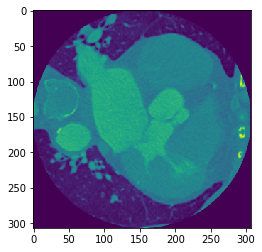

In [8]:
plt.imshow(img[0][:,:,112])

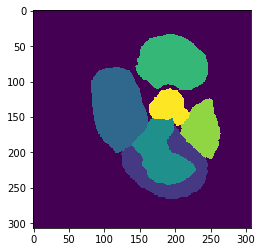

In [9]:
plt.imshow(label[0][:,:,112])

In [10]:
temp_img = copy.deepcopy(img[0][:,:,112])
temp_mask = copy.deepcopy(label[0][:,:,112])

In [11]:
np.unique(temp_mask)

array([0, 1, 2, 3, 4, 5, 6])

In [12]:
## 시각화를 위한 전처리
temp_mask[temp_mask>0] = 1400

In [13]:
# Define function to draw a grid
def draw_grid(im, grid_size):
    # Draw grid lines
    for i in range(0, im.shape[1], grid_size):
        cv2.line(im, (i, 0), (i, im.shape[0]), color=(0,0,0))
    for j in range(0, im.shape[0], grid_size):
        cv2.line(im, (0, j), (im.shape[1], j), color=(0,0,0))
        
draw_grid(temp_img, 10)
draw_grid(temp_mask, 10)

im_merge = np.concatenate((temp_img[...,None], temp_mask[...,None]), axis=2)

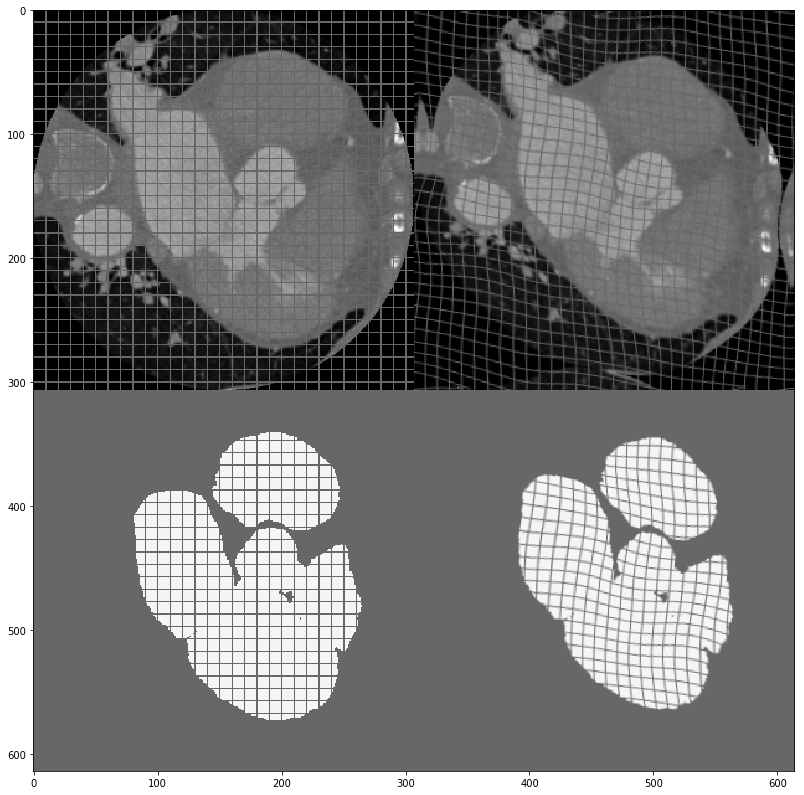

In [14]:
# First sample...

%matplotlib inline

# Apply transformation on image 
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] *0.08, im_merge.shape[1] * 0.08)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[temp_img, temp_mask], np.r_[im_t, im_mask_t]],cmap='gray')

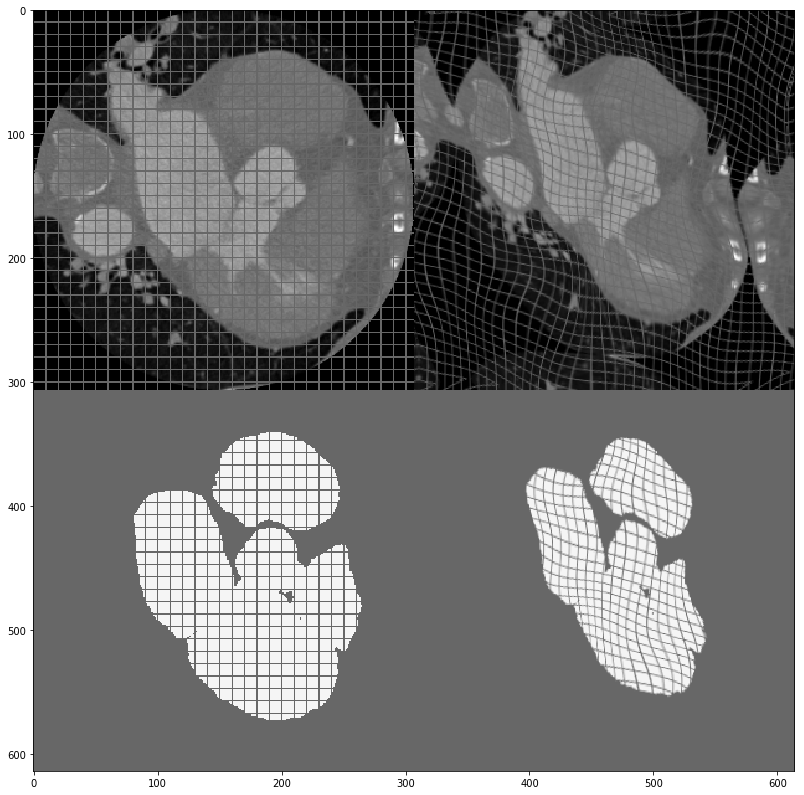

In [15]:
# Transfromation 더 크게

%matplotlib inline

# Apply transformation on image
im_merge_t = elastic_transform(im_merge, im_merge.shape[1] * 3, im_merge.shape[1] * 0.07, im_merge.shape[1] * 0.09)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[temp_img, temp_mask], np.r_[im_t, im_mask_t]], cmap='gray')

### 3D Elastic Deformation

In [16]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import cv2
import os
import numpy as np
from tqdm import tqdm

import torch as t
# t.backends.cudnn.benchmark = True
t.backends.cudnn.enabled = True
from torch.utils import data
from torchvision import transforms as tsf


def elastic_transform3Dv2(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
     From https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
    """
    # affine and deformation must be slice by slice and fixed for slices
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape # image is contatenated, the first channel [:,:,:,0] is the image, the second channel 
    # [:,:,:,1] is the mask. The two channel are under the same tranformation.
    shape_size = shape[:-1] # z y x
    # Random affine
    shape_size_aff = shape[1:-1] # y x
    center_square = np.float32(shape_size_aff) // 2
    square_size = min(shape_size_aff) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size],center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    new_img = np.zeros_like(image)
    for i in range(shape[0]):
        new_img[i,:,:,0] = cv2.warpAffine(image[i,:,:,0], M, shape_size_aff[::-1],borderMode=cv2.BORDER_CONSTANT, borderValue=0.)
        new_img[i,:,:,1] = cv2.warpAffine(image[i,:,:,1], M, shape_size_aff[::-1], flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_TRANSPARENT, borderValue=0)
            
            
    dx = gaussian_filter((random_state.rand(*shape[1:-1]) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape[1:-1]) * 2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape_size_aff[1]), np.arange(shape_size_aff[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    new_img2 = np.zeros_like(image)
    for i in range(shape[0]):
        new_img2[i,:,:,0] = map_coordinates(new_img[i,:,:,0], indices, order=1, mode='constant').reshape(shape[1:-1])
        new_img2[i,:,:,1] = map_coordinates(new_img[i,:,:,1], indices, order=0, mode='constant').reshape(shape[1:-1])
    return np.array(new_img2), new_img

In [17]:
temp_img_3d = copy.deepcopy(img[0])
temp_mask_3d = copy.deepcopy(label[0])

In [18]:
im_merge = np.concatenate([temp_img_3d[...,None]] + [temp_mask_3d[...,None]], axis=3)

In [19]:
im_merge.shape

(307, 307, 217, 2)

In [20]:

%matplotlib inline

# Apply transformation on image 
im_merge_t, new_img = elastic_transform3Dv2(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] *0.08, min(im_merge.shape[1:-1])*0.01)

# Split image and mask
im_t = im_merge_t[...,0]
im_mask_t = im_merge_t[...,1]

# # Display result
# plt.figure(figsize = (16,14))
# plt.imshow(np.c_[np.r_[temp_img_3d, temp_mask_3d], np.r_[im_t, im_mask_t]],cmap='gray')

In [21]:
im_merge_t.shape

(307, 307, 217, 2)

In [22]:
new_img.shape

(307, 307, 217, 2)

In [23]:
np.unique(im_merge_t)

array([-1024.        , -1024.        , -1024.        , ...,
        2654.02156743,  2672.2686127 ,  2677.8742322 ])

In [24]:
np.unique(new_img)

array([-1024.        , -1024.        , -1024.        , ...,
        2776.72275271,  2807.14941119,  2813.33657614])

In [25]:
np.unique(temp_img_3d)

array([-1024.        , -1024.        , -1024.        , ...,
        3038.48018765,  3046.61813316,  3051.05732566])

In [26]:
np.unique(temp_mask_3d)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [27]:
temp_mask_3d.dtype

dtype('int32')

In [28]:
np.unique(im_mask_t)

array([-512.        , -512.        , -512.        , ...,  384.37414353,
        391.93012151,  420.11618422])

In [29]:
np.unique(new_img[...,1])

array([-512.        , -512.        , -512.        , ...,  420.11618422,
        445.41739714,  472.31506137])

In [30]:
image = im_merge
alpha = im_merge.shape[1] * 2
sigma = im_merge.shape[1] *0.08
alpha_affine = min(im_merge.shape[1:-1])*0.01  
random_state = None
    
    
"""Elastic deformation of images as described in [Simard2003]_ (with modifications).
.. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
     Convolutional Neural Networks applied to Visual Document Analysis", in
     Proc. of the International Conference on Document Analysis and
     Recognition, 2003.
 Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
 From https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
"""
# affine and deformation must be slice by slice and fixed for slices
if random_state is None:
    random_state = np.random.RandomState(None)
shape = image.shape # image is contatenated, the first channel [:,:,:,0] is the image, the second channel 
# [:,:,:,1] is the mask. The two channel are under the same tranformation.
shape_size = shape[:-1] # z y x
# Random affine
shape_size_aff = shape[1:-1] # y x
center_square = np.float32(shape_size_aff) // 2
square_size = min(shape_size_aff) // 3
pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size],center_square - square_size])
pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
M = cv2.getAffineTransform(pts1, pts2)
new_img = np.zeros_like(image)
for i in range(shape[0]):
    new_img[i,:,:,0] = cv2.warpAffine(image[i,:,:,0], M, shape_size_aff[::-1],borderMode=cv2.BORDER_CONSTANT, borderValue=0.)
    new_img[i,:,:,1] = cv2.warpAffine(image[i,:,:,1], M, shape_size_aff[::-1], flags=cv2.INTER_NEAREST,borderMode=cv2.BORDER_TRANSPARENT, borderValue=0)

In [31]:
dx = gaussian_filter((random_state.rand(*shape[1:-1]) * 2 - 1), sigma) * alpha
dy = gaussian_filter((random_state.rand(*shape[1:-1]) * 2 - 1), sigma) * alpha
x, y = np.meshgrid(np.arange(shape_size_aff[1]), np.arange(shape_size_aff[0]))
indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
new_img2 = np.zeros_like(image)
for i in range(shape[0]):
    new_img2[i,:,:,0] = map_coordinates(image[i,:,:,0], indices, order=1, mode='constant').reshape(shape[1:-1])
    new_img2[i,:,:,1] = map_coordinates(image[i,:,:,1], indices, order=0, mode='constant').reshape(shape[1:-1])

In [32]:
new_img2

array([[[[-1024.,     0.],
         [-1024.,     0.],
         [-1024.,     0.],
         ...,
         [    0.,     0.],
         [    0.,     0.],
         [    0.,     0.]],

        [[-1024.,     0.],
         [-1024.,     0.],
         [-1024.,     0.],
         ...,
         [    0.,     0.],
         [    0.,     0.],
         [    0.,     0.]],

        [[-1024.,     0.],
         [-1024.,     0.],
         [-1024.,     0.],
         ...,
         [    0.,     0.],
         [    0.,     0.],
         [    0.,     0.]],

        ...,

        [[    0.,     0.],
         [    0.,     0.],
         [    0.,     0.],
         ...,
         [-1024.,     0.],
         [-1024.,     0.],
         [-1024.,     0.]],

        [[    0.,     0.],
         [    0.,     0.],
         [    0.,     0.],
         ...,
         [-1024.,     0.],
         [-1024.,     0.],
         [-1024.,     0.]],

        [[    0.,     0.],
         [    0.,     0.],
         [    0.,     0.],
         ...,
 

In [1]:
### Mask Fixed 

from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter
import cv2
import os
import numpy as np
from tqdm import tqdm


def elastic_transform3D_fixed(image, alpha, sigma, alpha_affine, random_state=None):
    """Elastic deformation of images as described in [Simard2003]_ (with modifications).
    .. [Simard2003] Simard, Steinkraus and Platt, "Best Practices for
         Convolutional Neural Networks applied to Visual Document Analysis", in
         Proc. of the International Conference on Document Analysis and
         Recognition, 2003.
     Based on https://gist.github.com/erniejunior/601cdf56d2b424757de5
     From https://www.kaggle.com/bguberfain/elastic-transform-for-data-augmentation
     
    Using Only map_coordinates for deforming mask
     
    """
    # affine and deformation must be slice by slice and fixed for slices
    if random_state is None:
        random_state = np.random.RandomState(None)
    shape = image.shape # image is contatenated, the first channel [:,:,:,0] is the image, the second channel 
    # [:,:,:,1] is the mask. The two channel are under the same tranformation.
    shape_size = shape[:-1] # z y x
    # Random affine
    shape_size_aff = shape[1:-1] # y x
    center_square = np.float32(shape_size_aff) // 2
    square_size = min(shape_size_aff) // 3
    pts1 = np.float32([center_square + square_size, [center_square[0]+square_size, center_square[1]-square_size],center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)

    dx = gaussian_filter((random_state.rand(*shape[1:-1]) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape[1:-1]) * 2 - 1), sigma) * alpha
    x, y = np.meshgrid(np.arange(shape_size_aff[1]), np.arange(shape_size_aff[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))
    new_img2 = np.zeros_like(image)
    for i in range(shape[0]):
        new_img2[i,:,:,0] = map_coordinates(image[i,:,:,0], indices, order=1, mode='constant').reshape(shape[1:-1])
        new_img2[i,:,:,1] = map_coordinates(image[i,:,:,1], indices, order=0, mode='constant').reshape(shape[1:-1])
    return np.array(new_img2[:,:,:,0]), np.array(new_img2[:,:,:,1])

In [34]:
trans_img, trans_label = elastic_transform3D_fixed(im_merge, im_merge.shape[1] * 2, im_merge.shape[1] *0.08, min(im_merge.shape[1:-1])*0.01)

In [35]:
trans_img.shape

(307, 307, 217, 2)

In [36]:
## Check
np.unique(trans_img[...,1])

array([0., 1., 2., 3., 4., 5., 6., 7.])

In [37]:
## Inspecting Image
trans_img_slice  =  trans_img[150,:,:,0]
trans_mask_slice  = trans_label[150,:,:,1]

In [38]:
trans_img_slice.shape

(307, 217)

In [39]:
temp_img_3d = copy.deepcopy(img[0])
temp_mask_3d = copy.deepcopy(label[0])

In [40]:
temp_img_slice = temp_img_3d[150, :, : ]
temp_mask_slice =  temp_mask_3d[150, :, : ]

In [41]:
temp_img_slice.shape

(307, 217)

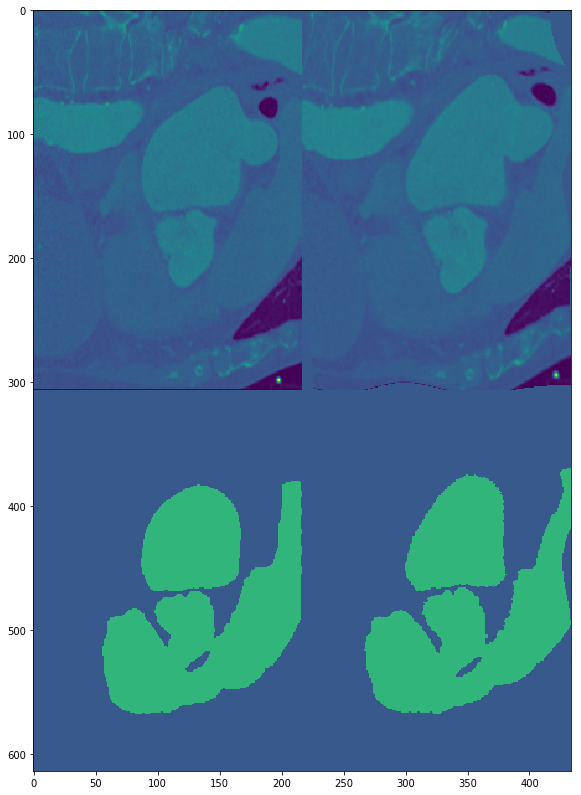

In [42]:
## 시각화를 위한 전처리
temp_mask_slice[temp_mask_slice>0] = 1400
trans_mask_slice[trans_mask_slice>0] = 1400

# Display result
plt.figure(figsize = (16,14))
plt.imshow(np.c_[np.r_[temp_img_slice, temp_mask_slice], np.r_[trans_img_slice, trans_mask_slice]])

### 3D 성공
* notebook 정리
* code 첨부해서 git push
